Mount Drive and navigate to datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = "/content/drive/Shareddrives/CS286-project/VLM-Segmentation-Project/Data/BiomedParseData"
%cd $base_path

Mounted at /content/drive
/content/drive/Shareddrives/CS286-project/VLM-Segmentation-Project/Data/BiomedParseData


Connect to Hugging Face to download BiomedParse

In [ ]:
from google.colab import userdata
import huggingface_hub


huggingface_hub.login(userdata.get('HF_TOKEN'))

# Loading BiomedParse

In [ ]:
import os
if not os.path.exists("pretrained"):
  from huggingface_hub import hf_hub_download

  model_file = hf_hub_download(repo_id="microsoft/BiomedParse", filename="biomedparse_v1.pt", local_dir="pretrained")

  print(f"Downloaded model file to: {model_file}")
  !git clone https://github.com/microsoft/BiomedParse

## BiomedParse dependencies

In [ ]:
!pip install -r BiomedParse/assets/requirements/requirements.txt

  Cloning https://github.com/MaureenZOU/detectron2-xyz.git to /tmp/pip-req-build-ogaq3oup
  Running command git clone --filter=blob:none --quiet https://github.com/MaureenZOU/detectron2-xyz.git /tmp/pip-req-build-ogaq3oup
  Resolved https://github.com/MaureenZOU/detectron2-xyz.git to commit 42121d75e10d9f858f3a91b6a39f5722c02868f0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Setting up BiomedParse

In [ ]:
!ls

all_data.pickle			  inference_examples_DICOM.ipynb
assets				  inference_examples_NIFTI.ipynb
biomedparse_datasets		  inference_examples_RGB.ipynb
biomedparse_working.txt		  inference_utils
BreastUS_metrics.csv		  LGG_metrics.csv
BreastUS_vqa.csv		  LGG_metrics_old.csv
configs				  LGG_vqa.csv
CT-Abdomen_rotate.gif		  LICENSE
CXR_Masks_and_Labels_metrics.csv  modeling
CXR_Masks_and_Labels_vqa.csv	  oldUWaterlooSkinCancer_metrics.csv
datasets			  oldUWaterlooSkinCancer_vqa.csv
docker				  pipeline
entry.py			  pretrained
environment.yml			  __pycache__
example_prediction.py		  README.md
examples			  SECURITY.md
figures				  site_correct.png
gemini_image_descriptor.py	  trainer
GlaS_metrics.csv		  utilities
GlaS_vqa.csv			  UWaterlooSkinCancer_metrics.csv
inference_colab_demo.ipynb	  UWaterlooSkinCancer_vqa.csv


In [ ]:
%cd BiomedParse

/content/drive/Shareddrives/CS286-project/VLM-Segmentation-Project/Data/BiomedParseData/BiomedParse


In [ ]:
from PIL import Image
import torch
import argparse
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed # changed from utils
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
from inference_utils.inference import interactive_infer_image

conf_files = "configs/biomedparse_inference.yaml"
opt = load_opt_from_config_files([conf_files])
opt = init_distributed(opt)

model_file = "../pretrained/biomedparse_v1.pt"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BaseModel(opt, build_model(opt)).from_pretrained(model_file).eval().to(device=device)
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

# Dataset Processing

## ontology files

## image files

In [ ]:
import json

In [ ]:
dataset_names = ['CXR_Masks_and_Labels', 'GlaS', 'LGG', 'ACDC', 'BreastUS', 'COVID-19_CT', 'COVID-QU-Ex', 'FH-PS-AOP', 'NeoPolyp', 'OCT-CME', 'REFUGE', 'UWaterlooSkinCancer']
def retrieve_dataset(name, train=True):
  '''
  returns dict containing
  'file_path' of image
  'site', 'modality', 'height', 'width',
  'masks' a list of 'num_masks' dicts
    each dict containing
    'object_type'
    'file_path' of mask
    and other metadata
  'num_masks'
  '''
  ds_path = base_path + '/' + name
  if train:
    dataset_outline = json.load(open(ds_path + '/train.json'))
  else:
    dataset_outline = json.load(open(ds_path + '/test.json'))

  images = dataset_outline['images']
  categories = dataset_outline['categories']
  annotations = dataset_outline['annotations']
  # group caregories by category_id
  category_names = {category['id']: category['name'] for category in categories}

  # group mask annotations by image id
  masks = {}
  for annotation in annotations:
    if annotation['image_id'] not in masks:
      masks[annotation['image_id']] = []
    annotation['category_name'] = category_names[annotation['category_id']]
    if train:
      annotation['file_path'] = ds_path + '/' + 'train_mask' + '/' + annotation['mask_file']
    else:
      annotation['file_path'] = ds_path + '/' + 'test_mask' + '/' + annotation['mask_file']
    annotation['object_type'] = annotation['mask_file'].split('_')[-1].split('.')[0].replace('+', ' ')
    masks[annotation['image_id']].append(annotation)

  ds = {}
  for image in images:
    modality = image['file_name'].split('_')[-2]
    site = image['file_name'].split('_')[-1].split('.')[0]

    if train:
      file_path = ds_path + '/' + 'train' + '/' + image['file_name']
    else:
      file_path = ds_path + '/' + 'test' + '/' + image['file_name']

    ds[image['id']] = {'file_path': file_path, 'site': site, 'modality': modality, 'height': image['height'], 'width': image['width'], 'masks': masks[image['id']], 'num_masks':len(masks[image['id']])}
  return ds

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from PIL import Image

class BiomedParseDataset(Dataset):
  def __init__(self, dataset_name, train=True):
    self.dataset = retrieve_dataset(dataset_name, train)
    self.name = dataset_name

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    datapoint = self.dataset[idx]

    # 3 x 1024 x 1024 tensor
    image = Image.open(datapoint['file_path']).convert('RGB')

    # list of 1024 x 1024 tensors
    masks = {}
    # masks['file_paths'] = []
    for mask in datapoint['masks']:
      mask_img = Image.open(mask['file_path']).convert('L')
      masks[mask['object_type']] = mask_img
      # masks['file_paths'].append(mask['file_path'])

    site = datapoint['site']
    modality = datapoint['modality']
    # height = datapoint['height']
    # width = datapoint['width']
    # num_masks = datapoint['num_masks']

    return {'site':site, 'modality':modality, 'image':image, 'masks':masks, 'file_path':datapoint['file_path']}

A custom Dataset class to traverse through selected objects in the different datasets for our demo. We pick the first two images in each case.

In [ ]:
class MergedDataset(Dataset):
  def __init__(self, datasets):
    self.datasets = datasets
    self.mapping = {0: (0, 0),
                    1: (1, 0),
                    2: (2, 0),
                    3: (3, 0),
                    4: (4, 0),
                    5: (0, 1),
                    6: (1, 1),
                    7: (2, 1),
                    8: (3, 1),
                    9: (4, 1),
                    }
  def __len__(self):
    return len(self.mapping)

  def __getitem__(self, index):
    ds_idx, img_idx = self.mapping[index]
    self.name = self.datasets[ds_idx].name
    return self.datasets[ds_idx][img_idx]

ds = MergedDataset([BiomedParseDataset(dataset_names[idx], train=False) for idx in [0, 1, 2, 4, len(dataset_names) - 1]])

In [ ]:
# ds = BiomedParseDataset(dataset_names[2], train=False)

# High Level Pipelines

In [ ]:
import matplotlib.pyplot as plt

## This file captures all the VQA prompting strategies. We include it along with this .ipynb file as a separate .py file

In [ ]:
from gemini_image_descriptor import describe_image

In [ ]:
# prompt: load the csv file into a df, find the row where the column file_path matches the query string

import pandas as pd

def find_row_by_filepath(df, query_string):
  """
  Finds the row in a DataFrame where the 'file_path' column matches the query string.

  Args:
    df: The input DataFrame.
    query_string: The string to search for in the 'file_path' column.

  Returns:
    The row as a pandas Series if found, otherwise None.
  """
  matching_rows = df[df['image_path'] == query_string]
  if not matching_rows.empty:
    return matching_rows.iloc[0]
  else:
    return None

## Building the agentic system and evaluations

In [ ]:

def VQAPipeline(image_path, csv_path, load_from_csv=False):
  if not load_from_csv:
    pred_site, pred_modality, pred_object_types, *_ = describe_image(image_path, csv_path, 0)
  else:
    row = find_row_by_filepath(pd.read_csv(csv_path), image_path)
    pred_site = row['site']
    pred_modality = row['modality']
    pred_object_types = eval(row['object_types'])
  pred_object_types = set([x.split(',')[-1].strip() for x in pred_object_types])
  return pred_site, pred_modality, pred_object_types

def VQAPipelineHierarchical(image_path, csv_path, load_from_csv=False):
  if not load_from_csv:
    pred_site, pred_modality, pred_object_types, *_ = describe_image(image_path, csv_path, 0)
  else:
    row = find_row_by_filepath(pd.read_csv(csv_path), image_path)
    pred_site = row['site']
    pred_modality = row['modality']
    pred_object_types = eval(row['object_types'])
  pred_object_types = set([(x.split(',')[-1].strip(), x.count(',')) for x in pred_object_types])
  pred_objects = [x[0] for x in pred_object_types]
  hierarchy_lvl = [x[1] for x in pred_object_types]
  return pred_site, pred_modality, pred_objects, hierarchy_lvl

def VQAEval(preds, gold):
  site, modality, objects = gold
  pred_site, pred_modality, pred_objects = preds
  site_correct = site.lower() == pred_site.lower()
  modality_correct = modality.lower() == pred_modality.lower()
  IoU_object_types = len(set(pred_objects).intersection(set(objects)))/len(set(objects).union(set(pred_objects)))
  recall_object_types = len(set(pred_objects).intersection(set(objects)))/len(set(objects))

  return site_correct, modality_correct, IoU_object_types, recall_object_types

def generate_prompts(site, modality, object_types):
  sentence_templates = {}
  for object_type in object_types:
    # can replace with other sentence structures
    sentence_templates[(site, modality, object_type)] = f"{object_type}"# in {site} {modality}"
  return sentence_templates

def BiomedParseModel(image, sentence_template):
  pred_mask = interactive_infer_image(model, image, sentence_template)
  return pred_mask

def BiomedParsePipeline(image, sentence_templates):
  pred_masks = {}
  for key, sentence_template in sentence_templates.items():
    site, modality, object_type = key
    pred_mask = 1*(BiomedParseModel(image, sentence_template) > 0.5)
    valid = True
    if np.sum(pred_mask) == 0:
      valid = False
    pred_masks[object_type] = {'mask':pred_mask, 'valid':valid}

  return pred_masks

# EDIT this one only
def BiomedParsePipelineCopy(image, sentence_templates):
  pred_masks = {}
  for key, sentence_template in sentence_templates.items():
    site, modality, object_type = key
    pred_mask = 1*(BiomedParseModel(image, sentence_template) > 0.5)
    valid = True
    if np.sum(pred_mask) == 0:
      valid = False
    pred_mask = Image.fromarray(pred_mask.squeeze(0), mode='L')
    pred_masks[object_type] = {'mask':pred_mask, 'valid':valid}

  return pred_masks

def dice_score(pred_mask, gold_mask):
  inputs = pred_mask
  targets = gold_mask
  numerator = 2 * (inputs * targets).sum()
  denominator = inputs.sum() + targets.sum()
  return (numerator + 1) / (denominator + 1)

def BiomedParseEval(pred_masks, gold_masks):
  pred_mask_objects = set(pred_masks.keys())
  gold_mask_objects = set(gold_masks.keys())
  intersection = pred_mask_objects.intersection(gold_mask_objects)
  dice_list = {}
  valid = 0
  total = len(gold_mask_objects)
  for object_type in intersection:
    if pred_masks[object_type]['valid']:
      valid += 1
      pred_mask = torch.tensor(pred_masks[object_type]['mask']).to(int)
      gold_mask = (torch.tensor(np.array(gold_masks[object_type]))/255.0).to(int)
      dice = dice_score(pred_mask, gold_mask)
      dice_list[object_type] = dice
  return dice_list, valid/total

## Evaluation and visualization script

In [ ]:
import pandas as pd
import os

# Create a CSV file if it doesn't exist
# metrics_logger_csv = f'{ds.name}_metrics.csv'



for idx in range(len(ds)):

  datapoint = ds[idx]
  VQA_logger_csv = f"{ds.name}_vqa.csv"
  image_path = datapoint['file_path']
  gold_site = datapoint['site']
  gold_modality = datapoint['modality']
  image = datapoint['image']
  gold_masks = datapoint['masks']
  if 'glandular structure' in gold_masks.keys() and ds.name == 'GlaS':
    gold_masks['colon glandular structure'] = gold_masks.pop('glandular structure')
  if 'MRI' in gold_modality:
    gold_modality = 'MRI'
  gold_object_types = list(gold_masks.keys())

  # VQA
  pred_site, pred_modality, pred_object_types = VQAPipeline(image_path, VQA_logger_csv, True)
  print(f"{pred_site=}, {pred_modality=}, and {pred_object_types=}")
  # VQA eval
  site_correct, modality_correct, IoU_object_types, recall_object_types = VQAEval(preds=(pred_site, pred_modality, pred_object_types), gold=(gold_site, gold_modality, gold_object_types))

  # VQA to BiomedParse
  pred_sentence_templates = generate_prompts(pred_site, pred_modality, pred_object_types)
  pred_masks_VQA_prompts = BiomedParsePipeline(image, pred_sentence_templates)
  dice_vqa, fraction_valid_vqa = BiomedParseEval(pred_masks_VQA_prompts, gold_masks)
  union_objects = set(pred_masks_VQA_prompts.keys()).union(set(gold_masks.keys()))
  pred_mask = np.zeros((1024, 1024))
  for object_type in union_objects:
      if object_type in pred_masks_VQA_prompts.keys():
        pred_mask = pred_masks_VQA_prompts[object_type]['mask'].squeeze(0)
      else:
        pred_mask = np.zeros_like(pred_mask)

      if object_type in gold_masks.keys():
        gold_mask = gold_masks[object_type]
      else:
        gold_mask = np.zeros_like(pred_mask)
      fig, axes = plt.subplots(1, 3, figsize=(12, 6))
      axes[0].imshow(pred_mask, cmap='gray')
      axes[1].imshow(gold_mask, cmap='gray')
      axes[2].imshow(image)
      plt.title(f'object type = {object_type}')
      plt.show()
  # Just BiomedParse
  gold_sentence_templates = generate_prompts(gold_site, gold_modality, gold_object_types)

  pred_masks_gold_prompts = BiomedParsePipeline(image, gold_sentence_templates)

  dice_gold, fraction_valid_gold = BiomedParseEval(pred_masks_gold_prompts, gold_masks)
  for dice_val, (object_type, pred_mask) in zip(dice_gold.values(), pred_masks_gold_prompts.items()):
      pred_mask = pred_mask['mask'].squeeze(0)
      gold_mask = gold_masks[object_type]
      fig, axes = plt.subplots(1, 3, figsize=(12, 6))
      axes[0].imshow(pred_mask, cmap='gray')
      axes[1].imshow(gold_mask, cmap='gray')
      axes[2].imshow(image)
      plt.show()

  new_row = pd.DataFrame({
    'image_path': [image_path],
    'site_correct': [site_correct],
    'modality_correct': [modality_correct],
    'IoU_object_types': [IoU_object_types],
    'recall_object_types': [recall_object_types],
    'dice_vqa':[dice_vqa],
    'fraction_valid_vqa':[fraction_valid_vqa],
    'dice_gold':[dice_gold],
    'fraction_valid_gold':[fraction_valid_gold],
  })
  # Append the new row to the existing CSV file for VQA eval
  # if not os.path.isfile(metrics_logger_csv):
  #   new_row.to_csv(metrics_logger_csv, index=False)
  # new_df = pd.read_csv(metrics_logger_csv)
  # updated_df = pd.concat([new_df, new_row], ignore_index=True)
  # updated_df.to_csv(metrics_logger_csv, index=False)

['organ, lung, lower lung lobe', 'organ, lung, right lung', 'organ, lung, lung', 'organ', 'organ, lung, upper lung lobe', 'organ, lung, left lung', 'organ, heart anatomies', 'organ, lung', 'organ, heart anatomies, heart']
pred_site='chest', pred_modality='X-Ray', and pred_object_types={'heart', 'organ', 'left lung', 'heart anatomies', 'lung', 'lower lung lobe', 'upper lung lobe', 'right lung'}


KeyboardInterrupt: 

# Compiling Metrics

In [ ]:
# prompt: load the metrics_log.csv into a dataframe and print the first row

import pandas as pd
ds_name = dataset_names[0]
metrics_logger_csv = f'{ds_name}_metrics.csv'

df = pd.read_csv(metrics_logger_csv)

In [ ]:
df['site_correct'].mean()

In [ ]:
df['modality_correct'].mean()

In [ ]:
df['IoU_object_types'].mean()

In [ ]:
df['recall_object_types'].mean()

In [ ]:
from torch import tensor
dice_scores = []
for row in df['dice_vqa']:
  row = eval(row)
  if len(row) > 0:
    dice_scores.extend(list(row.values()))

import statistics
statistics.median(dice_scores)

tensor(0.9718)

In [ ]:
df['fraction_valid_vqa'].mean()

In [ ]:
from torch import tensor
dice_scores = []
for row in df['dice_gold']:
  row = eval(row)
  if len(row) > 0:
    dice_scores.extend(list(row.values()))

import statistics
statistics.median(dice_scores)

In [ ]:
df['fraction_valid_gold'].mean()

In [ ]:
import pandas as pd

In [ ]:
dataset_indices = [0, 1, 2, 4, len(dataset_names)-1]
barplot_y = ['site_correct', 'modality_correct', 'IoU_object_types', 'recall_object_types', 'fraction_valid_vqa', 'fraction_valid_gold']
df_concat_dict = {}
for y_name in barplot_y:
  df_dict = {}
  for dataset_idx in dataset_indices:
    ds_name = dataset_names[dataset_idx]
    metrics_csv = f'{ds_name}_metrics.csv'
    df = pd.read_csv(metrics_csv)

    df = df[y_name].to_frame()

    df['dataset'] = ds_name.replace('_', ' ')
    df_dict[dataset_idx] = df.copy()

  df_concat_dict[y_name] = pd.concat(list(df_dict.values()), ignore_index=True)

df_concat_full = pd.concat(list(df_concat_dict.values()), axis=1)
result_df = df_concat_full.loc[:, ~df_concat_full.columns.duplicated()]


In [ ]:
ds_names = [dataset_names[dataset_idx] for dataset_idx in dataset_indices]
print(ds_names)

['CXR_Masks_and_Labels', 'GlaS', 'LGG', 'BreastUS', 'UWaterlooSkinCancer']


In [ ]:
result_df.columns

Index(['site_correct', 'dataset', 'modality_correct', 'IoU_object_types',
       'recall_object_types', 'fraction_valid_vqa', 'fraction_valid_gold'],
      dtype='object')

<ipython-input-56-c852d911d115>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_concat_dict[y_name], y='dataset', x=y_name, orient='h', palette="Blues")


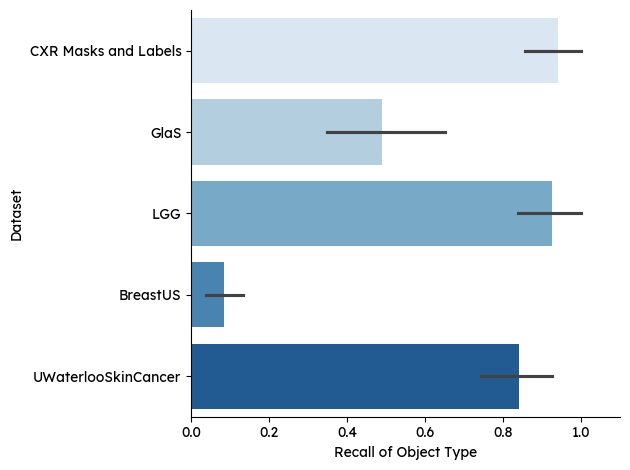

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

y_mapping = {'site_correct':"% correct site", 'modality_correct':"% correct modality", 'IoU_object_types': "IoU of Object Type", 'recall_object_types': "Recall of Object Type", 'fraction_valid_vqa':'Mask Recall from VQA-prompts', 'fraction_valid_gold':'Mask Recall from GT prompts'}
x_mapping = {'CXR_Masks_and_Labels':'CXR', 'GlaS':'GlaS','UWaterlooSkinCancer':'UWaterlooSkinCancer'}

y_name = barplot_y[3]
sns.barplot(data=df_concat_dict[y_name], y='dataset', x=y_name, orient='h', palette="Blues")
plt.xlabel(y_mapping[y_name])


import matplotlib.font_manager as fm

# Add the Lexend font
fm.fontManager.addfont('/content/Lexend-Regular.ttf')
plt.rcParams['font.family'] = 'Lexend'

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Dataset')
plt.xlim([0,1.1])
plt.tight_layout()
plt.savefig(f'/content/{y_name}.png')
plt.show()

In [ ]:
barplot_y = ['dice_vqa']
from torch import tensor
df_concat_dict = {}
for y_name in barplot_y:
  df_dict = {}
  for dataset_idx in dataset_indices:
    ds_name = dataset_names[dataset_idx]
    metrics_csv = f'{ds_name}_metrics.csv'
    df = pd.read_csv(metrics_csv)
    df = df[y_name]

    dice_scores = []
    organ_types = []
    for row in df:
      row = eval(row)
      if len(row) > 0:
        dice_scores.extend([x.item() for x in list(row.values())])
        organ_types.extend(list(row.keys()))

    df = pd.DataFrame({y_name:dice_scores, 'organ type':organ_types})

    df['dataset'] = ds_name.replace('_', ' ')
    df_dict[dataset_idx] = df

  df_concat_dict[y_name] = pd.concat(list(df_dict.values()), ignore_index=True)

df_concat_full = pd.concat(list(df_concat_dict.values()), axis=1)
result_df = df_concat_full.loc[:, ~df_concat_full.columns.duplicated()]

<ipython-input-14-c4831958e293>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_df, y='dataset', x='dice_vqa', orient='h', palette="Blues")


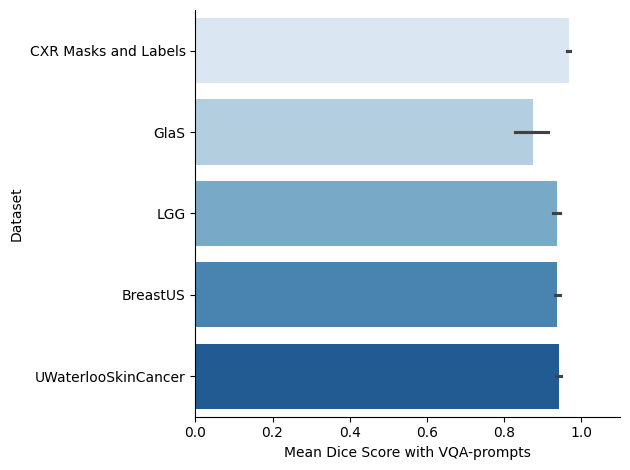

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=result_df, y='dataset', x='dice_vqa', orient='h', palette="Blues")
plt.xlabel('Mean Dice Score with VQA-prompts')
plt.xlim([0,1.1])

import matplotlib.font_manager as fm

# Add the Lexend font
fm.fontManager.addfont('/content/Lexend-Regular.ttf')
plt.rcParams['font.family'] = 'Lexend'

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Dataset')
plt.tight_layout()
plt.savefig('/content/dice_vqa.png')
plt.show()

In [ ]:
barplot_y = ['dice_gold']
from torch import tensor
df_concat_dict = {}
for y_name in barplot_y:
  df_dict = {}
  for dataset_idx in dataset_indices:
    ds_name = dataset_names[dataset_idx]
    metrics_csv = f'{ds_name}_metrics.csv'
    df = pd.read_csv(metrics_csv)
    df = df[y_name]

    dice_scores = []
    organ_types = []
    for row in df:
      row = eval(row)
      if len(row) > 0:
        dice_scores.extend([x.item() for x in list(row.values())])
        organ_types.extend(list(row.keys()))

    df = pd.DataFrame({y_name:dice_scores, 'organ type':organ_types})

    df['dataset'] = ds_name.replace('_', ' ')
    df_dict[dataset_idx] = df

  df_concat_dict[y_name] = pd.concat(list(df_dict.values()), ignore_index=True)

df_concat_full = pd.concat(list(df_concat_dict.values()), axis=1)
result_df = df_concat_full.loc[:, ~df_concat_full.columns.duplicated()]

<ipython-input-19-98eaede227b1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_df, y='dataset', x='dice_gold', orient='h', palette='Blues')


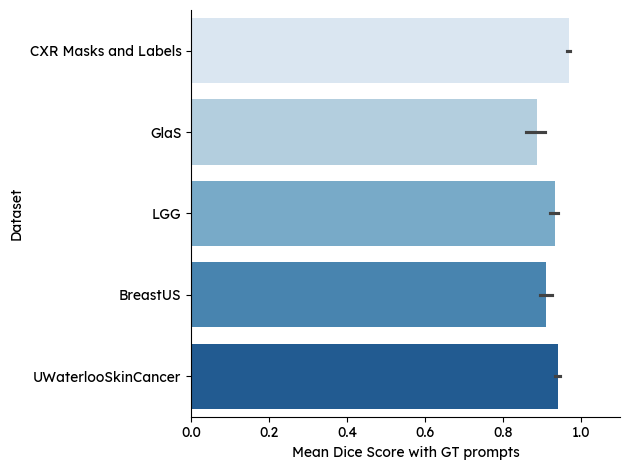

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=result_df, y='dataset', x='dice_gold', orient='h', palette='Blues')
plt.xlabel('Mean Dice Score with GT prompts')
plt.xlim([0,1.1])
plt.ylabel('Dataset')


import matplotlib.font_manager as fm

# Add the Lexend font
fm.fontManager.addfont('/content/Lexend-Regular.ttf')
plt.rcParams['font.family'] = 'Lexend'

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('/content/dice_gold.png')
plt.show()

# Constructing image, mask instances for the demo

In [ ]:
import pandas as pd
import os

# Create a CSV file if it doesn't exist
# metrics_logger_csv = f'{ds.name}_metrics.csv'


all_data = []

for idx in range(len(ds)):

  datapoint = ds[idx]
  VQA_logger_csv = f"{ds.name}_vqa.csv"
  image_path = datapoint['file_path']
  gold_site = datapoint['site']
  gold_modality = datapoint['modality']
  image = datapoint['image']
  gold_masks = datapoint['masks']
  if 'glandular structure' in gold_masks.keys() and ds.name == 'GlaS':
    gold_masks['colon glandular structure'] = gold_masks.pop('glandular structure')
  gold_object_types = list(gold_masks.keys())

  # VQA
  pred_site, pred_modality, pred_object_types, hierarchy_levels = VQAPipelineHierarchical(image_path, VQA_logger_csv, True)
  print(f"{pred_site=}, {pred_modality=}, {pred_object_types=}, {hierarchy_levels=}")
  # VQA eval
  # site_correct, modality_correct, IoU_object_types, recall_object_types = VQAEval(preds=(pred_site, pred_modality, pred_object_types), gold=(gold_site, gold_modality, gold_object_types))

  # VQA to BiomedParse
  masks_total = {}
  for hierarchy_level in set(hierarchy_levels):
    pred_objects_subset = [pred_object_types[i] for i in range(len(hierarchy_levels)) if hierarchy_levels[i] == hierarchy_level]
    pred_sentence_templates = generate_prompts(pred_site, pred_modality, pred_objects_subset)
    pred_masks_VQA_prompts = BiomedParsePipelineCopy(image, pred_sentence_templates)
    masks_total[hierarchy_level] = pred_masks_VQA_prompts

  datapoint_dict = {'image':image, 'mask_data':masks_total}
  all_data.append(datapoint_dict)


KeyboardInterrupt: 

In [ ]:
# prompt: create a pickle file storing the list all_data

import pickle

# Assuming 'all_data' is defined in your previous code

with open('all_data.pickle', 'wb') as f:
  pickle.dump(all_data, f)

In [ ]:
# prompt: load all_data from the pickle file and print the first element

import pickle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

with open('/content/all_data.pickle', 'rb') as f:
  all_data = pickle.load(f)

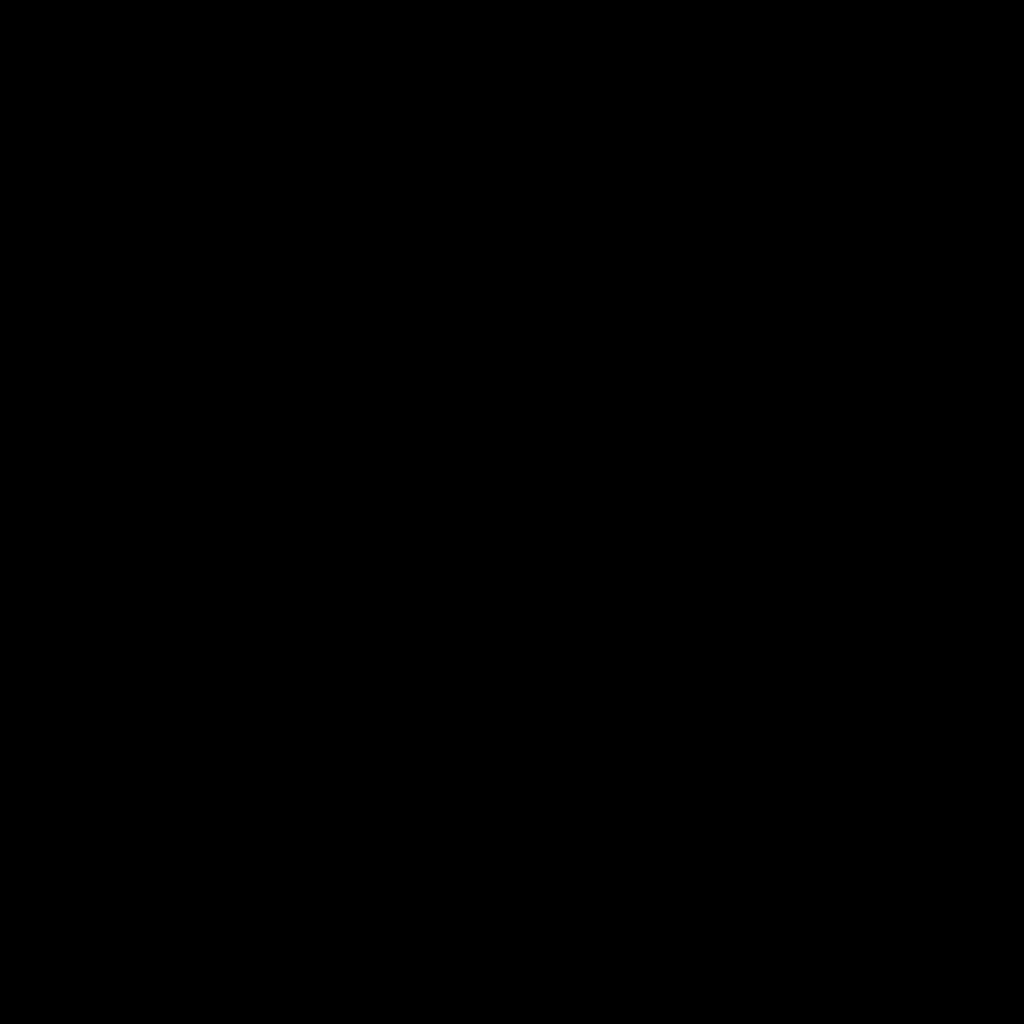

In [ ]:
all_data[1]['mask_data'][1]['histology structure']['mask']

In [ ]:
# prompt: iterate through all_data and print the entry valid

for entry in all_data:
  for hierarchy_level, masks in entry['mask_data'].items():
    for object_type, mask_info in masks.items():
      if mask_info['valid']:
        print(f"Valid mask found for object: {object_type} at hierarchy level: {hierarchy_level}")
      else:
        print(f"No valid mask found for object: {object_type} at hierarchy level: {hierarchy_level}")

In [ ]:
print(hierarchy_levels)